## Install libraries

In [1]:
# Library for HMM
!pip3 install --upgrade --user hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 4.0 MB/s eta 0:00:00


In [2]:
# Restart kernel after installing the package.

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import libraries

In [2]:
import sys
import os
import io
import logging

from google.cloud import bigquery
from google.cloud import storage

import dask.dataframe as dd
#from dask.distributed import Client
from google.cloud import bigquery
from dask import delayed
import pandas as pd
from sklearn.utils import check_random_state
from scipy.stats import entropy

import concurrent.futures
import ast

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Python packages for data, stats
import numpy as np
import pandas as pd
import seaborn as sns
import random

# ML
import sklearn
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# To get the time
from datetime import datetime

# To write on the same line
from IPython.display import clear_output

# Set a random seed for reproducibility
random_seed = 42

# Setting the random seed for various libraries
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import norm


# Hidden Markov Models
#from hmmlearn import hmm, vhmm
from hmmlearn.hmm import GaussianHMM
from hmmlearn.vhmm import VariationalGaussianHMM
from sklearn.utils import check_random_state


# Print different versions
print(sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Sklearn version:", sklearn.__version__)

# Display the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy version: 1.25.2
Pandas version: 2.0.3
Seaborn version: 0.13.1
Sklearn version: 1.2.2
Number of GPUs: 0


## Variables

In [3]:
# Pick the width of the genomic windows
GENOMIC_LENGTH = 250 # 250 or 1000 (1000 is not fully implemented yet)

# GCP variables
storage_client = storage.Client()
bq_client = bigquery.Client()
#dask_client = Client()
PROJECT_ID = "hmh-em-deepasm"
BUCKET_NAME = 'hmh_deepasm'
#LOCAL_DIR = str(GENOMIC_LENGTH) + "_bp/"
ML_DATASET = "ml_250bp"



## Functions used in Notebook

### HMM functions

In [ ]:
# # def fit_hmm_gaussian_model(sequence, n_components=2, covariance_type='full', n_iter=100):
# #     """
# #     Fit a Gaussian Hidden Markov Model (HMM) to a given sequence array.
# #     Each sequence is treated individually with its features.
# #     """

# #     # Determine the number of features per step in the sequence dynamically
# #     num_features = sequence.shape[-1]

# #     print(f"Num features: {num_features}")

# #     # Determine the length of each sequence dynamically
# #     sequence_length = sequence.shape[1]

# #     print(f"Sequence length: {sequence_length}")

# #     # Each sequence has a length determined by the second dimension of the input array
# #     lengths = [sequence_length] * len(sequence)

# #     # Flatten the sequences for the fit function, maintaining the number of features per step
# #     reshaped_data = sequence.reshape(-1, num_features)

# #     model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter)
# #     model.fit(reshaped_data, lengths)
# #     return model


# def fit_hmm_gaussian_model_cpg_frac(sequence, n_components=2, covariance_type='full', n_iter=100):
#     """
#     Fit a Gaussian Hidden Markov Model (HMM) to a given sequence array.
#     The sequence is an array of floats, representing observable data points.
#     """

#     print(f"Number of components: {n_components}")
#     print(f"Covariance type: {covariance_type}")
#     print(f"Number of iterations: {n_iter}")

#     sequence = np.atleast_2d(sequence).T

#     # Determine the length of the sequence dynamically
#     sequence_length = sequence.shape[0]

#     print(f"Sequence length: {sequence_length}")

#     # For a single sequence, the lengths list contains just one element: the sequence length
#     lengths = [sequence_length]

#     # The data is already in the right shape, so no need to reshape
#     reshaped_data = sequence

#     model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter)
#     model.fit(sequence, lengths)
#     return model

# def fit_hmm_gaussian_model(sequence, n_components=2, covariance_type='full', n_iter=100):
#     """
#     Fit a Gaussian Hidden Markov Model (HMM) to a given sequence array.
#     The sequence can be an array of floats or a 2D array of vectors,
#     representing observable data points.
#     """

#     print(f"Number of components: {n_components}")
#     print(f"Covariance type: {covariance_type}")
#     print(f"Number of iterations: {n_iter}")

#     # Ensure sequence is at least 2D and correctly shaped for HMM
#     # If sequence is 1D, reshape it to (n_samples, 1)
#     # If sequence is 2D, assume it's already in (n_samples, n_features) format
#     if sequence.ndim == 1:
#         sequence = np.atleast_2d(sequence).T
#     elif sequence.ndim > 2:
#         raise ValueError("Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)")

#     # Determine the length of the sequence dynamically
#     sequence_length = sequence.shape[0]

#     print(f"Sequence length: {sequence_length}")

#     # For a single sequence, the lengths list contains just one element: the sequence length
#     lengths = [sequence_length]

#     # The data is already in the right shape, so no need to reshape
#     reshaped_data = sequence

#     model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter)
#     model.fit(reshaped_data, lengths)
#     return model


# def predict_hidden_states(model, sequence, log_frequency=5000):
#     """
#     Predicts the hidden states for a series of methylation sequences using a
#     trained HMM model. Each sequence's hidden states are predicted individually.
#     """

#     hidden_states_all_sequences = []

#     for i, sequence in enumerate(sequence):
#         # Ensure the sequence is in the correct shape for model prediction, maintaining the number of features
#         hidden_states = model.predict(sequence)  # Predict the hidden states for this sequence
#         hidden_states_all_sequences.append(hidden_states)

#         # Optionally log the progress
#         if (i + 1) % log_frequency == 0:
#             print(f"Processed sequence number: {i + 1}")

#     return hidden_states_all_sequences

# # def predict_asm_using_hmm(model_0,
# #                           model_1,
# #                           sequence,
# #                           log_frequency=5000):
# #     """
# #     Predicts the hidden states for a series of methylation sequences using a
# #     trained HMM model. Each sequence's hidden states are predicted individually.
# #     """

# #     scores = []

# #     for i, sequence in enumerate(sequence):
# #         score_0 = model_0.score(sequence)
# #         score_1 = model_1.score(sequence)
# #         if score_0 > score_1:
# #             scores.append(0)
# #         else:
# #             scores.append(1)

# #         # Optionally log the progress
# #         if (i + 1) % log_frequency == 0:
# #             print(f"Processed sequence number: {i + 1}")

# #     return scores


# def predict_asm_using_hmm(model_0,
#                           model_1,
#                           sequence,
#                           log_frequency=5000):
#     """
#     Predicts the hidden states for a series of methylation sequences using a
#     trained HMM model. Each sequence's hidden states are predicted individually.
#     """

#     scores = []

#     for i, sequence in enumerate(sequence):
#         sequence_reshaped = np.atleast_2d(new_sequence).T
#         score_0 = model_0.score(sequence_reshaped)
#         score_1 = model_1.score(sequence_reshaped)
#         if score_0 > score_1:
#             scores.append(0)
#         else:
#             scores.append(1)

#         # Optionally log the progress
#         if (i + 1) % log_frequency == 0:
#             print(f"Processed sequence number: {i + 1}")

#     return scores


# def predict_asm_using_one_model(model, sequences, log_frequency=5000):
#     """
#     Predicts the scores for a series of sequences using a trained HMM model.
#     Each sequence's score is calculated individually.

#     Parameters:
#     - model: The trained HMM model.
#     - sequences: An array of arrays, where each inner array is a sequence of observable data points.
#     - log_frequency: Frequency of logging progress.

#     Returns:
#     - scores: A NumPy array of log likelihood scores for each sequence.
#     """
#     # Initialize a NumPy array for scores
#     scores = np.zeros(len(sequences))

#     for i, seq in enumerate(sequences):
#         # Ensure seq is in the right shape (n_samples, n_features)
#         seq_reshaped = np.atleast_2d(seq).T

#         # Calculate the score (log likelihood) for the sequence
#         score = model.score(seq_reshaped)
#         scores[i] = score

#         # Log progress
#         if (i + 1) % log_frequency == 0:
#             print(f"Processed sequence number: {i + 1}")

#     return scores


# def predict_hidden_states_for_sequences(model, sequences, log_frequency=100000):
#     """
#     Predicts the most likely hidden states for each element in a series of sequences using a trained HMM model.
#     Each sequence is processed individually, and the predicted states for each sequence are returned.

#     Parameters:
#     - model: The trained HMM model.
#     - sequences: An array of arrays, where each inner array is a sequence of observable data points.
#     - log_frequency: Frequency of logging progress.

#     Returns:
#     - predicted_states: A list of arrays, each containing the predicted hidden states for a sequence.
#     """
#     predicted_states = []


#     for i, sequence in enumerate(sequences):

#         # Convert sequence to a NumPy array if it's not already one
#         sequence = np.asarray(sequence)

#         # Ensure seq is in the right shape (n_samples, n_features)
#         if sequence.ndim == 1:
#           sequence = np.atleast_2d(sequence).T
#         elif sequence.ndim > 2:
#           raise ValueError("Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)")

#         # Predict the most likely hidden states for the sequence
#         states = model.predict(sequence)
#         predicted_states.append(states)

#         # Log progress
#         if (i + 1) % log_frequency == 0:
#             print(f"Processed sequence number: {i + 1}")

#     return predicted_states


In [4]:
def predict_hidden_states_for_sequences(model, sequences, log_frequency=100000):
    """
    Predicts the most likely hidden states for each element in a series of sequences using a trained Hidden Markov Model (HMM).
    Each sequence of observable data points is processed individually to determine the sequence's hidden states. These states represent the underlying process assumed by the HMM.

    Parameters:
    - model: The trained HMM model used for prediction.
    - sequences: A list of sequences, where each sequence is an array of numeric observable data points. Each inner array represents a sequence to be processed.
    - log_frequency: Specifies the interval of sequences processed at which progress is logged. Logging occurs every 'log_frequency' sequences.

    Returns:
    - predicted_states: A list where each element is an array of the predicted hidden states for a corresponding input sequence.

    """
    predicted_states = []

    for i, sequence in enumerate(sequences):

        # Convert sequence to a NumPy array if it's not already one
        sequence = np.asarray(sequence)

        # Ensure seq is in the right shape (n_samples, n_features)
        if sequence.ndim == 1:
            sequence = np.atleast_2d(sequence).T
        elif sequence.ndim > 2:
            raise ValueError(
                "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
            )

        # Predict the most likely hidden states for the sequence
        states = model.predict(sequence)
        predicted_states.append(states)

        # Log progress
        if (i + 1) % log_frequency == 0:
            logging.info(f"Processed sequence number: {i + 1}")

    return predicted_states

In [21]:
def extract_features(hidden_states_sequences):
    """
    Extracts a comprehensive set of features from sequences of hidden states in a Hidden Markov Model (HMM) and provides descriptive names for each feature.

    Parameters:
    - hidden_states_sequences (list of list of int): A list of sequences, where each sequence is a list of integers representing the hidden states visited by the HMM.

    Returns:
    - Tuple: A tuple containing a 2D NumPy array of extracted features for each sequence and a list of descriptive names for each feature.
    """

    features = []
    feature_names = []  # To store names of the features

    # Determine all unique states across sequences for consistent ordering
    unique_states = sorted({state for seq in hidden_states_sequences for state in seq})

    for state in unique_states:
        feature_names.append(f"count_state_{state}")
        feature_names.append(f"proportion_state_{state}")

    for i, state_i in enumerate(unique_states):
        for j, state_j in enumerate(unique_states):
            feature_names.append(f"transition_from_{state_i}_to_{state_j}")

    feature_names.extend(["start_state", "end_state", "nb_state_changes"])

    for state in unique_states:
        feature_names.append(f"mean_duration_state_{state}")
        feature_names.append(f"variance_duration_state_{state}")

    for i, state_i in enumerate(unique_states):
        for j, state_j in enumerate(unique_states):
            feature_names.append(f"transition_probability_from_{state_i}_to_{state_j}")

    feature_names.append("entropy_state_distribution")

    for seq in hidden_states_sequences:
        seq = np.array(seq)
        sequence_features = []

        # Original features: Counts, Proportions, and Transitions
        for state in unique_states:
            count = np.sum(seq == state)
            proportion = count / len(seq)
            sequence_features.extend([count, proportion])

        # Count transitions for later use in calculating probabilities
        transitions_matrix = np.zeros((len(unique_states), len(unique_states)))
        for i, state_i in enumerate(unique_states):
            for j, state_j in enumerate(unique_states):
                transition_count = np.sum((seq[:-1] == state_i) & (seq[1:] == state_j))
                transitions_matrix[i, j] = transition_count
                sequence_features.append(transition_count)

        start_state = seq[0]
        end_state = seq[-1]
        sequence_features.extend([start_state, end_state])

        # New features
        state_changes = np.sum(seq[:-1] != seq[1:])
        sequence_features.append(state_changes)

        # Duration in States, Mean & Variance of Stay Durations
        state_durations = {state: [] for state in unique_states}
        current_state = seq[0]
        current_duration = 1
        for i in range(1, len(seq)):
            if seq[i] == current_state:
                current_duration += 1
            else:
                state_durations[current_state].append(current_duration)
                current_state = seq[i]
                current_duration = 1
        state_durations[current_state].append(current_duration)  # for the last state

        for state, durations in state_durations.items():
            if durations:
                mean_duration = np.mean(durations)
                var_duration = np.var(durations)
            else:
                mean_duration = 0
                var_duration = 0
            sequence_features.extend([mean_duration, var_duration])

        # Transition Probabilities
        for i in range(len(unique_states)):
            for j in range(len(unique_states)):
                total_transitions_from_i = np.sum(transitions_matrix[i, :])
                if total_transitions_from_i > 0:
                    transition_prob = (
                        transitions_matrix[i, j] / total_transitions_from_i
                    )
                else:
                    transition_prob = 0
                sequence_features.append(transition_prob)

        # Entropy of State Distribution
        state_counts = np.array(
            [np.sum(seq == state) for state in unique_states], dtype=float
        )
        state_probs = (
            state_counts / state_counts.sum()
            if state_counts.sum() > 0
            else np.zeros_like(state_counts)
        )
        sequence_entropy = entropy(
            state_probs
        )  # scipy's entropy function calculates from probabilities
        sequence_features.append(sequence_entropy)

        features.append(sequence_features)

    return np.array(features), feature_names

### Print classification results

In [5]:
def print_classification_results(y_true, y_pred):
    """
    Prints the classification results for a given set of true and predicted labels.
    """

    report = classification_report(y_true, y_pred, output_dict = True)

    label1_f1 = report['1']['f1-score']
    label2_f1 = report['0']['f1-score']

    print(f"Sum of the f1 scores: {np.round(label1_f1 + label2_f1, 2)}")

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))


## Download data for ML

In [6]:
dic_data = {'train': {'samples': ['gm12878',
                                  'CD14',
                                  'fibroblast',
                                  'A549',
                                  'spleen_female_adult',
                                  'HeLa_S3']},
            # 'validation': {'samples': ['mammary_epithelial',
            #                            'sk_n_sh',
            #                            'CD34']},
            'test': {'samples': ['HepG2',
                                 'righ_lobe_liver',
                                 't_cell_male_adult']}}

In [7]:
# Sequence of CpG cov and methylation
table_id = 'features_wo_hmm'
var_seq = 'cpg_directional_fm'
nb_for_training = 100000  # 200000
nb_for_testing = 100000   # 100000
for dataset_name, samples in dic_data.items():
    print("Samples", samples['samples'])
    quoted_samples = ",".join([f"'{sample}'" for sample in samples['samples']])
    print(f"Quotes samples: {quoted_samples}")

    if dataset_name == 'train':
        query = f"SELECT asm,sample,chr, {var_seq} FROM {PROJECT_ID}.{ML_DATASET}.{table_id} WHERE sample IN ({quoted_samples}) AND {var_seq} IS NOT NULL AND asm IS NOT NULL LIMIT {nb_for_training}"
        dic_data[dataset_name]['imported'] = bq_client.query(query).to_dataframe()
    else:
        query = f"SELECT asm, sample, chr, {var_seq} FROM {PROJECT_ID}.{ML_DATASET}.{table_id} WHERE sample IN ({quoted_samples}) AND {var_seq} IS NOT NULL AND asm IS NOT NULL LIMIT {nb_for_testing}"
        dic_data[dataset_name]['imported'] = bq_client.query(query).to_dataframe()


#  ORDER BY RAND() LIMIT {nb_for_testing}

Samples ['gm12878', 'CD14', 'fibroblast', 'A549', 'spleen_female_adult', 'HeLa_S3']
Quotes samples: 'gm12878','CD14','fibroblast','A549','spleen_female_adult','HeLa_S3'
Samples ['HepG2', 'righ_lobe_liver', 't_cell_male_adult']
Quotes samples: 'HepG2','righ_lobe_liver','t_cell_male_adult'


In [8]:
for dataset in dic_data.keys():
  dic_data[dataset]['imported'][var_seq] = dic_data[dataset]['imported'][var_seq].apply(lambda x: ast.literal_eval(x.strip('"')))

dic_data['train']['imported']

,asm,sample,chr,cpg_directional_fm
0,0,A549,4,"[1.0, 1.0, 1.0]"
1,0,A549,4,"[0.7, 0.4, 0.3]"
2,0,A549,4,"[0.9, 0.7, 1.0]"
3,0,A549,4,"[0.5, 0.3, 0.2]"
4,0,A549,4,"[0.1, 0.1, 0.7, 0.1]"
...,...,...,...,...
99995,0,spleen_female_adult,8,"[0.3, 0.3, 0.1, 0.2, 0.5]"
99996,0,spleen_female_adult,8,"[0.1, 0.2, 0.2, 0.1, 0.2, 0.2]"
99997,0,spleen_female_adult,8,"[0.5, 0.4, 0.3, 0.4, 0.3, -0.1]"
99998,0,spleen_female_adult,8,"[0.0, 0.0, 0.1, 0.1, 0.3, 0.5, -0.1]"


In [9]:
# For CpG coverage and methylation
for dataset_name in dic_data.keys():
  dic_data[dataset_name]['all_observations'] = np.concatenate(dic_data[dataset_name]["imported"][var_seq].tolist())#np.array(np.concatenate(dic_data[dataset_name]['imported'][var_seq].values))


In [ ]:
len(dic_data['train']['all_observations'])

448735

## Compute weights of ASM labels for training

In [10]:
neg, pos = np.bincount(dic_data['test']['imported']['asm'])
total = neg + pos
print('Number of regions assessed for ASM: {}\nRegions with ASM found: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

class_weight_asm = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Number of regions assessed for ASM: 100000
Regions with ASM found: 2506 (2.51% of total)

Weight for class 0: 0.51
Weight for class 1: 19.95


## HMM models

### Train two HMM and compare their respective scores

In [ ]:
dic_hmm_models = {}

In [ ]:
dic_data['train']['seq_array_wo_asm']

In [ ]:
sequence

array([0.1, 0.5, 0.3, 0.6, 0.2, 0.4])

In [ ]:
sequence = np.array([0.1, 0.5, 0.3, 0.6, 0.2, 0.4])
model = fit_hmm_gaussian_model(dic_data['train']['seq_array_wo_asm'], n_components=1, covariance_type='diag', n_iter=100)


Number of components: 1
Covariance type: diag
Number of iterations: 100
Sequence length: 545


In [ ]:
# Score a new sequence with the trained model
new_sequence = np.array([0.3, 0.4, 0.5])
new_sequence_reshaped = np.atleast_2d(new_sequence).T  # Reshape for scoring
score = model.score(new_sequence_reshaped)
print(f"Score (log likelihood) of the new sequence: {score}")


Score (log likelihood) of the new sequence: -1.1926893016034728


In [ ]:
dic_data['test']['seq_arrays']

0                                [0.0, 0.2, 0.161, 0.037]
1                                    [0.961, 0.941, 0.92]
2                            [0.981, 0.981, 0.969, 0.959]
3       [0.745, 0.761, 0.784, 0.885, 0.889, 0.8, 0.857...
4                                  [0.035, 0.0, 0.0, 0.0]
                              ...                        
9995    [0.043, 0.0, 0.019, 0.017, 0.0, 0.0, 0.0, 0.0,...
9996                             [0.0, 0.054, 0.024, 0.0]
9997                                    [0.023, 0.0, 0.0]
9998    [0.963, 0.548, 1.0, 1.0, 0.274, 0.688, 0.837, ...
9999           [0.923, 0.886, 0.711, 0.865, 0.727, 0.733]
Name: sequence_cpg_fm, Length: 10000, dtype: object

In [ ]:
# Gaussian does not lead
for n_components in [1,2,3,4,5]:
  for cov_name in ['diag', 'full', 'spherical', 'tied']:
    for n_iterations in [100, 200, 300]:
      print("****************************************")
      print(f"n_components: {n_components}, covariance_type: {cov_name}, n_iterations: {n_iterations}")
      print("**********************")
      print("Training model for label 0")
      model_label0 = fit_hmm_gaussian_model(
          dic_data['train']['seq_array_wo_asm'],
          n_components, cov_name, n_iterations
          )
      print("Training model for label 1")
      model_label1 = fit_hmm_gaussian_model(
          dic_data['train']['seq_array_w_asm'],
          n_components, cov_name, n_iterations
          )
      print("Predicting test")
      scores = predict_asm_using_hmm(model_label0,
                                model_label1,
                                dic_data['test']['seq_arrays'],
                                log_frequency=5000)
      print_classification_results(dic_data['test']['labels'], scores)


## Train one HMM model

In [11]:
def prepare_data_for_hmm(sequence):
    """
    Prepares a sequence of data for processing with a Hidden Markov Model (HMM).

    This function ensures the input sequence is in a 2D NumPy array format required by HMM processing routines, handling both single-dimensional sequences (interpreting them as a sequence of scalar observations) and two-dimensional sequences (interpreting them as a sequence of vector observations). It also calculates the length of the sequence, which is necessary for some HMM algorithms.

    Parameters:
    - sequence (np.ndarray): The input sequence to be processed. This can be either a 1D array of scalar observations or a 2D array of vector observations, where each row represents a timestep.

    Returns:
    - sequence (np.ndarray): The input sequence reshaped into a 2D NumPy array format, with individual observations along rows.
    - lengths (list of int): A list containing a single integer, which is the length of the input sequence. This is used by HMM algorithms that require the lengths of sequences being processed.

    Raises:
    - ValueError: If the input `sequence` has more than two dimensions, indicating it's not in an acceptable format for HMM processing.
    """

    if sequence.ndim == 1:
        sequence = np.atleast_2d(sequence).T
    elif sequence.ndim > 2:
        raise ValueError(
            "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
        )

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    return sequence, lengths

In [12]:
# Prepare data for training
reshaped_data, lengths = prepare_data_for_hmm(dic_data['train']['all_observations'])


In [37]:
n_components = 7
rs = check_random_state(546)
cov_name = 'tied' # full, tied, spherical, diag
n_iterations = 200
n_mix = 1
algorithm='viterbi' # map or viterbi
startprob_prior = np.array([0.99, 0.01])
model_iterations = 3

best_ll = None
best_model = None
for i in range(model_iterations):
    print(f"Iteration: {i}")
    h = VariationalGaussianHMM(n_components,
                    n_iter=200,
                    covariance_type = 'tied',
                    algorithm = 'viterbi',
                    random_state=rs) # tol=1e-4,
    h.fit(reshaped_data, lengths)
    score = h.score(reshaped_data)
    print(f"score: {score}")
    if not best_ll or best_ll < best_ll:
        best_ll = score
        best_model = h

# model = GaussianHMM(n_components=n_components,
#                         covariance_type=cov_name,
#                         n_iter=n_iterations,
#                        #startprob_prior = startprob_prior,
#                         algorithm = algorithm,
#                         random_state = rs)

# model = hmm.GMMHMM(n_components=n_components,
#                         covariance_type=cov_name,
#                         n_iter=n_iterations,
#                         algorithm = algorithm,
#                    random_state = rs)


# NOT CONVERGING
# model = vhmm.VariationalGaussianHMM(n_components=n_components,
#                         covariance_type=cov_name,
#                         n_iter=n_iterations,
#                         random_state = rs,
#                         algorithm = algorithm)

# NOT CONVERGING
# model = hmm.PoissonHMM(n_components=n_components,
#                         n_iter=n_iterations
#                        )

# model = vhmm.VariationalCategoricalHMM(
#     n_components=n_components,
#     n_iter=n_iterations
#                                       )

# model = hmm.MultinomialHMM(n_components=n_components,
#                         n_iter=n_iterations,
#                            random_state = rs,
#                         algorithm = algorithm
#                        )


Iteration: 0
score: 33541.170639947835
Iteration: 1
score: 30203.317210341003
Iteration: 2
score: 30789.028634275695


In [38]:
print("\nStart probabilities:")
print(best_model.startprob_)

print("\nTransition matrix:")
print(best_model.transmat_)

print("\nGaussian distribution covariances:")
print(best_model.covars_)

print("\nGaussian means:")
print(best_model.means_)


# Z = model.predict(dic_data['train']['all_observations'])
# states = pd.unique(Z)
# print(f"Unique states: {states}")


Start probabilities:
[0.07142857 0.07142857 0.07143119 0.07142862 0.07142857 0.07142857
 0.5714259 ]

Transition matrix:
[[2.03192352e-01 4.68666057e-06 1.40717694e-01 4.68838578e-06
  4.46640648e-01 2.09435238e-01 4.69157653e-06]
 [9.43419505e-03 6.19979826e-01 1.20988526e-06 2.16603583e-01
  2.20007413e-05 1.20987654e-06 1.53957975e-01]
 [4.33190504e-01 1.50887188e-05 1.51523660e-05 1.50931560e-05
  4.88528893e-01 4.97466519e-03 7.32606026e-02]
 [1.12592037e-02 3.90536484e-01 1.24893943e-03 3.96899123e-01
  2.17889963e-06 2.17961860e-06 2.00051891e-01]
 [8.55135467e-02 9.71730758e-04 2.98733673e-02 4.27710688e-04
  8.74435721e-01 1.60488362e-04 8.61743558e-03]
 [4.30326664e-01 6.44231630e-02 1.18730158e-05 8.04106310e-02
  1.18696735e-05 4.24803927e-01 1.18721445e-05]
 [2.49259553e-06 3.19977476e-01 8.80424261e-03 2.25467783e-01
  1.86108425e-02 8.19675554e-03 4.18940408e-01]]

Gaussian distribution covariances:
[[[0.01403241]]

 [[0.01403241]]

 [[0.01403241]]

 [[0.01403241]]

 [[

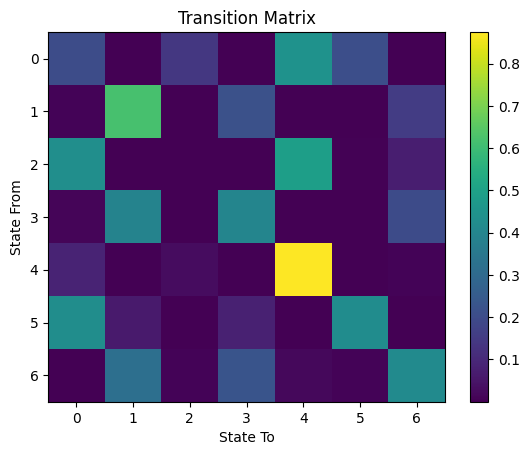

In [39]:
# Assuming best_model.transmat_ is defined and contains the transition matrix you want to plot
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the transition matrix
cax = ax.imshow(best_model.transmat_, aspect='auto')

# Create a colorbar with a reference to the imshow plot
fig.colorbar(cax)

# Set the title and labels
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')

# Display the plot
plt.show()

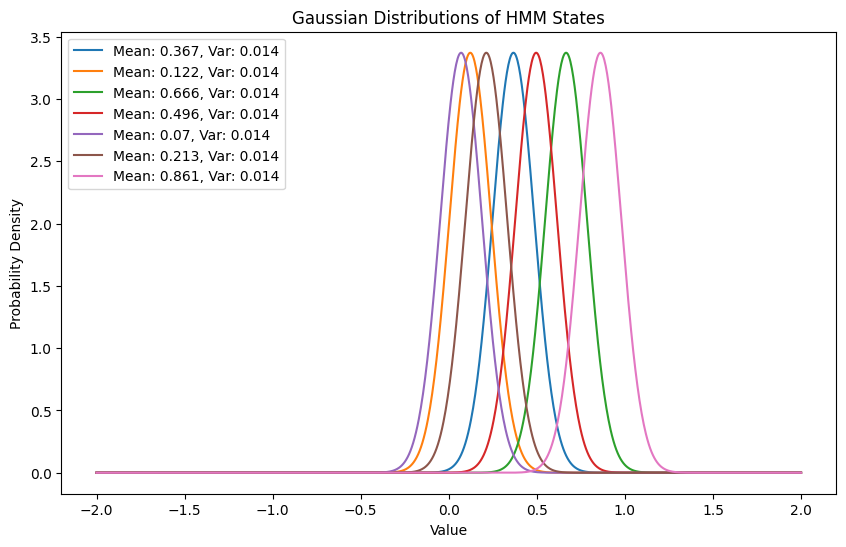

In [40]:

# Example Gaussian parameters for 5 states
means = np.round(best_model.means_.flatten(),3)  # [1, 3, 5, 7, 9]
covariances = np.round(best_model.covars_.flatten(),3) #[0.5, 0.2, 1.0, 0.3, 0.7]  # Variance in this case

# Create a figure
plt.figure(figsize=(10, 6))

# Value range for x-axis
x = np.linspace(-2, 2, 1000)

# Plot each Gaussian
for mean, cov in zip(means, covariances):
    plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), label=f'Mean: {mean}, Var: {cov}')

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

plt.show()


In [41]:
for dataset_type in ['train', 'test']:
  print(f"dataset: {dataset_type}")
  ###dic_data[dataset_type]['seq_scores'] = predict_asm_using_one_model(model, dic_data[dataset_type]['seq_arrays'])
  dic_data[dataset_type]['hidden_states'] = predict_hidden_states_for_sequences(best_model, dic_data[dataset_type]['imported'][var_seq])
  dic_data[dataset_type]['array_asm'] = np.array(dic_data[dataset_type]['imported']['asm'])

dataset: train
dataset: test


In [42]:
# Masks for selecting elements where the binary array is 0 or 1
dic_data['train']['average_hidden_states'] = np.array([np.mean(seq) for seq in dic_data['train']['hidden_states']])
for_calc = dic_data['train']['average_hidden_states']

mask_zeros = dic_data['train']['array_asm'] == 0
mask_ones = dic_data['train']['array_asm'] == 1

data_zeros = for_calc[mask_zeros]
data_ones = for_calc[mask_ones]


mean_zeros = np.mean(data_zeros)
std_dev_zeros = np.std(data_zeros)

# Statistics for elements corresponding to 1 in the binary array
mean_ones = np.mean(data_ones)
std_dev_ones = np.std(data_ones)

(mean_zeros, std_dev_zeros, mean_ones, std_dev_ones)

# Creating subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Regions without ASM", "Regions With ASM"))

# Adding histograms for each subset of data
fig.add_trace(go.Histogram(x=data_zeros, name='Zeros'), row=1, col=1)
fig.add_trace(go.Histogram(x=data_ones, name='Ones'), row=1, col=2)

# Updating layout for clarity
fig.update_layout(height=400, width=800, title_text="Distributions of average hidden states")
fig.update_traces(opacity=0.75)  # Adjusting opacity for better visualization

fig.show()


In [43]:
for dataset_type in dic_data.keys():
  print(f"Dataset: {dataset_type}")
  dic_data[dataset_type]['hs_features'], feature_names = extract_features(dic_data[dataset_type]['hidden_states'])
  dic_data[dataset_type]['hs_features'] = pd.DataFrame(dic_data[dataset_type]['hs_features'], columns=feature_names).reset_index(
            drop=True
        )


Dataset: train
Dataset: test


### XGBoost on the HMM features

In [24]:
import xgboost as xgb

In [44]:
# Include the weights later
var_for_training = 'hs_features'

dtrain = xgb.DMatrix(dic_data['train'][var_for_training], label=dic_data['train']['array_asm'])
dtest = xgb.DMatrix(dic_data['test'][var_for_training], label=dic_data['test']['array_asm'])

param = {
    'max_depth': 5,
    'eta': 0.01, # learning rate
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': ['logloss'],
    'subsample': 0.5,
    #'scale_pos_weight': 0.02  # Adjust based on your exact dataset
}
evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 500
bst = xgb.train(param, dtrain, num_round, evals = evallist)

[0]	train-logloss:0.16527	eval-logloss:0.18214
[1]	train-logloss:0.16404	eval-logloss:0.18089
[2]	train-logloss:0.16282	eval-logloss:0.17964
[3]	train-logloss:0.16162	eval-logloss:0.17842
[4]	train-logloss:0.16044	eval-logloss:0.17721
[5]	train-logloss:0.15926	eval-logloss:0.17601
[6]	train-logloss:0.15810	eval-logloss:0.17483
[7]	train-logloss:0.15696	eval-logloss:0.17366
[8]	train-logloss:0.15582	eval-logloss:0.17251
[9]	train-logloss:0.15471	eval-logloss:0.17137
[10]	train-logloss:0.15361	eval-logloss:0.17024
[11]	train-logloss:0.15251	eval-logloss:0.16912
[12]	train-logloss:0.15143	eval-logloss:0.16802
[13]	train-logloss:0.15036	eval-logloss:0.16693
[14]	train-logloss:0.14930	eval-logloss:0.16586
[15]	train-logloss:0.14826	eval-logloss:0.16479
[16]	train-logloss:0.14723	eval-logloss:0.16374
[17]	train-logloss:0.14621	eval-logloss:0.16270
[18]	train-logloss:0.14521	eval-logloss:0.16168
[19]	train-logloss:0.14421	eval-logloss:0.16066
[20]	train-logloss:0.14323	eval-logloss:0.15967
[2

In [45]:
ypred = bst.predict(dtest)
for threshold in [0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.115, 0.12, 0.125, 0.13, 0.15]:
  print("****************************")
  print(f"Threshold: {threshold}")
  pred_labels = (ypred > threshold).astype(int)
  #print(pred_labels)
  print_classification_results(dic_data['test']['array_asm'].astype(int), pred_labels)
#pred_labels = (ypred > threshold).astype(int)
#print_classification_results(dic_data['test']['array_asm'].astype(int), pred_labels)

****************************
Threshold: 0.01
Sum of the f1 scores: 1.1
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     97494
           1       0.12      0.95      0.21      2506

    accuracy                           0.81    100000
   macro avg       0.56      0.88      0.55    100000
weighted avg       0.98      0.81      0.88    100000

[[79079 18415]
 [  113  2393]]
****************************
Threshold: 0.02
Sum of the f1 scores: 1.23
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     97494
           1       0.17      0.90      0.29      2506

    accuracy                           0.89    100000
   macro avg       0.58      0.89      0.62    100000
weighted avg       0.98      0.89      0.92    100000

[[86746 10748]
 [  259  2247]]
****************************
Threshold: 0.05
Sum of the f1 scores: 1.37
              precision    recall  f1-score   support

           0  

In [ ]:
xgb.plot_importance(bst)


<Axes: >

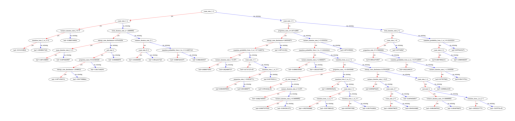

In [ ]:
xgb.plot_tree(bst, num_trees=2)


## Parking lot

In [ ]:
# Need integers
def fit_hmm_categorical_model(sequence, n_components, n_features, n_iterations):
    #sequence = np.atleast_2d(sequence).T

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    print(f"Sequence length: {sequence_length}")

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    # The data is already in the right shape, so no need to reshape
    #reshaped_data = sequence

    model = hmm.CategoricalHMM(n_components=n_components, n_features = n_features, n_iter = n_iterations)
    model.fit(sequence, lengths)
    return model

n_components = 2
cov_name = 'full'
#n_features = None # 1
n_iterations = 100
#n_mix = 1

model = fit_hmm_categorical_model(
          dic_data['train']['all_observations'],
          n_components,
          cov_name,
          n_iterations
          )

Sequence length: 59369


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [ ]:


# Need integers
def fit_hmm_poisson_model(sequence, n_components, n_features, n_iterations):
    sequence = np.atleast_2d(sequence).T

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    print(f"Sequence length: {sequence_length}")

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    # The data is already in the right shape, so no need to reshape
    reshaped_data = sequence

    model = hmm.CategoricalHMM(n_components=n_components, n_features = n_features, n_iter = n_iterations)
    model.fit(sequence, lengths)
    return model

def fit_hmm_gmm_model(sequence, n_components, n_mix, n_iterations):
    sequence = np.atleast_2d(sequence).T

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    print(f"Sequence length: {sequence_length}")

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    # The data is already in the right shape, so no need to reshape
    reshaped_data = sequence

    model = hmm.GMMHMM(n_components=n_components, n_mix = n_mix, n_iter = n_iterations)
    model.fit(sequence, lengths)
    return model


In [ ]:
n_components = 4
n_features = None # 1
n_iterations = 100
n_mix = 1

model_label0 = fit_hmm_gmm_model(
          dic_data['train']['seq_array_wo_asm'],
          n_components = n_components,
          n_mix = n_mix,
          n_iterations = n_iterations
          )
print("Training model for label 1")
model_label1 = fit_hmm_gmm_model(
    dic_data['train']['seq_array_w_asm'],
    n_components = n_components,
    n_mix = n_mix,
    n_iterations = n_iterations
    )
print("Predicting test")
scores = predict_asm_using_hmm(model_label0,
                          model_label1,
                          dic_data['test']['seq_arrays'],
                          log_frequency=5000)
print_classification_results(dic_data['test']['labels'], scores)

Sequence length: 6046
Training model for label 1
Sequence length: 6999
Predicting test
Processed sequence number: 5000
Processed sequence number: 10000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9793
           1       0.02      1.00      0.04       207

    accuracy                           0.02     10000
   macro avg       0.01      0.50      0.02     10000
weighted avg       0.00      0.02      0.00     10000

[[   0 9793]
 [   0  207]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
n_components = 1
n_features = None # 1
n_iterations = 100

model_label0 = fit_hmm_categorical_model(
          dic_data['train']['seq_array_wo_asm'],
          n_components = n_components,
          n_features = n_features
          )
print("Training model for label 1")
model_label1 = fit_hmm_categorical_model(
    dic_data['train']['seq_array_w_asm'],
    n_components = n_components,
    n_features = n_features
    )
print("Predicting test")
scores = predict_asm_using_hmm(model_label0,
                          model_label1,
                          dic_data['test']['seq_arrays'],
                          log_frequency=5000)
print_classification_results(dic_data['test']['labels'], scores)

Sequence length: 6046


ValueError: Symbols should be integers

### Train one single HMM and use the hidden states to infer ASM

In [ ]:
model1 = fit_hmm_gaussian_model(
    dic_ml_data['train']['methylation_matrix_array_flattened'],
    n_components=3, covariance_type='diag', n_iter=100
    )

In [ ]:
model2 = fit_hmm_gaussian_model(dic_ml_data['train']['methylation_matrix_converted_array'])

In [ ]:
# Pick model
model = model1

# Compute sequence likelihoods under the model
def compute_likelihoods(model, sequences, lengths):
    return np.array([model.score(seq.reshape(-1, 1)) for seq in sequences])

X_train = dic_ml_data['train']['methylation_matrix_array_flattened']
X_test = dic_ml_data['test']['methylation_matrix_array_flattened']
#train_lengths = [GENOMIC_LENGTH] * X_train.reshape(-1,

# Compute likelihoods for training and testing sets
train_likelihoods = compute_likelihoods(model, X_train, [GENOMIC_LENGTH] * len(X_train))
test_likelihoods = compute_likelihoods(model, X_test, [GENOMIC_LENGTH] * len(X_test))

y_train = dic_ml_data['train']['labels'].values.ravel()
y_test = dic_ml_data['test']['labels'].values.ravel()
# Train a classifier using the likelihoods as features
classifier = LogisticRegression()
classifier.fit(train_likelihoods.reshape(-1, 1), y_train)

# Predict on the test set
predictions = classifier.predict(test_likelihoods.reshape(-1, 1))

# Evaluate the classifier
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

KeyboardInterrupt: 

In [ ]:
model = model1

for dataset in ['train', 'test']:
    print(f"Dataset: {dataset}")
    methylation_sequence_array = dic_ml_data[dataset]['methylation_matrix_array_flattened']
    array_hidden_states = predict_hidden_states(model,
                                                methylation_sequence_array,
                                      )
    dic_ml_data[dataset]['hidden_states'] = array_hidden_states

X_train = dic_ml_data['train']['hidden_states']
X_test = dic_ml_data['test']['hidden_states']
y_train = dic_ml_data['train']['labels'].values.ravel()
y_test = dic_ml_data['test']['labels'].values.ravel()

classifier = RandomForestClassifier(class_weight=class_weight_asm)  # Handling class imbalance
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Dataset: train
Processed sequence number: 5000
Processed sequence number: 10000
Processed sequence number: 15000
Processed sequence number: 20000
Processed sequence number: 25000
Processed sequence number: 30000
Processed sequence number: 35000
Processed sequence number: 40000
Processed sequence number: 45000
Processed sequence number: 50000
Processed sequence number: 55000
Processed sequence number: 60000
Processed sequence number: 65000
Processed sequence number: 70000
Dataset: test
Processed sequence number: 5000
Processed sequence number: 10000
Processed sequence number: 15000
Processed sequence number: 20000
Processed sequence number: 25000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24697
           1       0.17      0.01      0.01       482

    accuracy                           0.98     25179
   macro avg       0.57      0.50      0.50     25179
weighted avg       0.97      0.98      0.97     25179

Confusion Matrix:
[

In [ ]:
len(X_train)

2930560

In [ ]:
len(y_train)

73264

In [ ]:
from sklearn.model_selection import train_test_split
# Example data generation
# Here you should load your data. This is just an example with random data.
num_sequences = 100  # Total number of sequences
sequence_length = 250  # Length of each sequence
num_features = 4  # 4 unique states from combining two binary variables

# Generate random sequences
X = np.random.randint(num_features, size=(num_sequences, sequence_length))
lengths = [sequence_length] * num_sequences  # Length of each sequence

# Generate random labels for the sequences
y = np.random.randint(2, size=num_sequences)  # Binary labels (0 or 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train HMM
# Initialize HMM; this example uses a Gaussian HMM, adjust according to your needs
model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100)

# Prepare data for HMM
train_data = np.concatenate(X_train)
train_lengths = [sequence_length] * len(X_train)

# Fit the HMM
model.fit(train_data.reshape(-1, 1), lengths=train_lengths)

# Compute sequence likelihoods under the model
def compute_likelihoods(model, sequences, lengths):
    return np.array([model.score(seq.reshape(-1, 1)) for seq in sequences])

# Compute likelihoods for training and testing sets
train_likelihoods = compute_likelihoods(model, X_train, train_lengths)
test_likelihoods = compute_likelihoods(model, X_test, [sequence_length] * len(X_test))

# Train a classifier using the likelihoods as features
classifier = LogisticRegression()
classifier.fit(train_likelihoods.reshape(-1, 1), y_train)

# Predict on the test set
predictions = classifier.predict(test_likelihoods.reshape(-1, 1))

# Evaluate the classifier
print(classification_report(y_test, predictions))




              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# # Prepare data for HMM model
# df = dic_ml_data['train']['methylation_matrix'].copy(deep = True)

# methylation_sequence_array_train = np.stack([row for row in df['methylation_matrix']],
#                                       axis = 0)

# lengths = [GENOMIC_LENGTH]*len(df)

# # Reshape to have 40-size vectors
# new_shape = methylation_sequence_array_train.shape[2]*methylation_sequence_array_train.shape[3]

# methylation_sequence_array_train = methylation_sequence_array_train.reshape(-1, new_shape)

# print(methylation_sequence_array_train.shape)


Genomic length: 250
(18316000, 40)


In [ ]:
methylation_sequence_array_train.shape

(18316000, 40)

In [ ]:
# Predict hidden states for the training and test datasets

for dataset in ['train', 'test']:
    print(f"Dataset: {dataset}")
    methylation_sequence_array = dic_ml_data[dataset]['methylation_matrix_converted_array']
    array_hidden_states = predict_hidden_states(model,
                                                methylation_sequence_array,
                                                GENOMIC_LENGTH)
    dic_ml_data[dataset]['hidden_states'] = array_hidden_states


Dataset: train
Total number of sequences to process: 73264


ValueError: shapes of a (1, 1) and b (40, 125) are incompatible

In [ ]:
# # Create a DataFrame from the hidden states sum
# df_hidden_states_sum = pd.DataFrame({
#     'hidden_states_sum': dic_ml_data['test']['hidden_states_sum']
# })

# # Assuming the index of dic_ml_data['labels'] matches the order of hidden_states_sum
# # Concatenate the two DataFrames along the columns
# df_combined = pd.concat([df_hidden_states_sum, dic_ml_data['test']['labels']], axis=1)

# # Assuming the column name in dic_ml_data['labels'] that you want to filter by is 'label'
# # Describe the data for labels == 0
# description_labels_0 = df_combined[df_combined[0] == 0]['hidden_states_sum'].describe()

# # Describe the data for labels == 1
# description_labels_1 = df_combined[df_combined[0] == 1]['hidden_states_sum'].describe()

# # You can print or return these descriptions as needed
# print("Description for labels == 0:")
# print(description_labels_0)
# print("\nDescription for labels == 1:")
# print(description_labels_1)

Description for labels == 0:
count    24697.000000
mean         6.431145
std          4.299558
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         56.000000
Name: hidden_states_sum, dtype: float64

Description for labels == 1:
count    482.000000
mean       7.263485
std        4.179829
min        3.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       35.000000
Name: hidden_states_sum, dtype: float64


## Test

In [ ]:
def prepare_data_for_hmm(sequence):
    """
    Prepares a sequence of data for processing with a Hidden Markov Model (HMM).

    This function ensures the input sequence is in a 2D NumPy array format required by HMM processing routines, handling both single-dimensional sequences (interpreting them as a sequence of scalar observations) and two-dimensional sequences (interpreting them as a sequence of vector observations). It also calculates the length of the sequence, which is necessary for some HMM algorithms.

    Parameters:
    - sequence (np.ndarray): The input sequence to be processed. This can be either a 1D array of scalar observations or a 2D array of vector observations, where each row represents a timestep.

    Returns:
    - sequence (np.ndarray): The input sequence reshaped into a 2D NumPy array format, with individual observations along rows.
    - lengths (list of int): A list containing a single integer, which is the length of the input sequence. This is used by HMM algorithms that require the lengths of sequences being processed.

    Raises:
    - ValueError: If the input `sequence` has more than two dimensions, indicating it's not in an acceptable format for HMM processing.
    """

    if sequence.ndim == 1:
        sequence = np.atleast_2d(sequence).T
    elif sequence.ndim > 2:
        raise ValueError(
            "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
        )

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    return sequence, lengths


def predict_hidden_states_for_sequences(model, sequences, log_frequency=100000):
    """
    Predicts the most likely hidden states for each element in a series of sequences using a trained Hidden Markov Model (HMM).
    Each sequence of observable data points is processed individually to determine the sequence's hidden states. These states represent the underlying process assumed by the HMM.

    Parameters:
    - model: The trained HMM model used for prediction.
    - sequences: A list of sequences, where each sequence is an array of numeric observable data points. Each inner array represents a sequence to be processed.
    - log_frequency: Specifies the interval of sequences processed at which progress is logged. Logging occurs every 'log_frequency' sequences.

    Returns:
    - predicted_states: A list where each element is an array of the predicted hidden states for a corresponding input sequence.

    """
    predicted_states = []

    for i, sequence in enumerate(sequences):

        # Convert sequence to a NumPy array if it's not already one
        sequence = np.asarray(sequence)

        # Ensure seq is in the right shape (n_samples, n_features)
        if sequence.ndim == 1:
            sequence = np.atleast_2d(sequence).T
        elif sequence.ndim > 2:
            raise ValueError(
                "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
            )

        # Predict the most likely hidden states for the sequence
        states = model.predict(sequence)
        predicted_states.append(states)

        # Log progress
        if (i + 1) % log_frequency == 0:
            logging.info(f"Processed sequence number: {i + 1}")

    return predicted_states


def extract_features(hidden_states_sequences):
    """
    Extracts a comprehensive set of features from sequences of hidden states in a Hidden Markov Model (HMM) and provides descriptive names for each feature.

    Parameters:
    - hidden_states_sequences (list of list of int): A list of sequences, where each sequence is a list of integers representing the hidden states visited by the HMM.

    Returns:
    - Tuple: A tuple containing a 2D NumPy array of extracted features for each sequence and a list of descriptive names for each feature.
    """
    # logging.info(f"Hidden states: {hidden_states_sequences}")

    features = []
    feature_names = []  # To store names of the features

    # Determine all unique states across sequences for consistent ordering
    unique_states = sorted({state for seq in hidden_states_sequences for state in seq})

    for state in unique_states:
        feature_names.append(f"count_state_{state}")
        feature_names.append(f"proportion_state_{state}")

    for i, state_i in enumerate(unique_states):
        for j, state_j in enumerate(unique_states):
            feature_names.append(f"transition_from_{state_i}_to_{state_j}")

    feature_names.extend(["start_state", "end_state", "nb_state_changes"])

    for state in unique_states:
        feature_names.append(f"mean_duration_state_{state}")
        feature_names.append(f"variance_duration_state_{state}")

    for i, state_i in enumerate(unique_states):
        for j, state_j in enumerate(unique_states):
            feature_names.append(f"transition_probability_from_{state_i}_to_{state_j}")

    feature_names.append("entropy_state_distribution")

    for seq in hidden_states_sequences:
        seq = np.array(seq)
        sequence_features = []

        # Original features: Counts, Proportions, and Transitions
        for state in unique_states:
            count = np.sum(seq == state)
            proportion = count / len(seq)
            sequence_features.extend([count, proportion])

        # Count transitions for later use in calculating probabilities
        transitions_matrix = np.zeros((len(unique_states), len(unique_states)))
        for i, state_i in enumerate(unique_states):
            for j, state_j in enumerate(unique_states):
                transition_count = np.sum((seq[:-1] == state_i) & (seq[1:] == state_j))
                transitions_matrix[i, j] = transition_count
                sequence_features.append(transition_count)

        start_state = seq[0]
        end_state = seq[-1]
        sequence_features.extend([start_state, end_state])

        # New features
        state_changes = np.sum(seq[:-1] != seq[1:])
        sequence_features.append(state_changes)

        # Duration in States, Mean & Variance of Stay Durations
        state_durations = {state: [] for state in unique_states}
        current_state = seq[0]
        current_duration = 1
        for i in range(1, len(seq)):
            if seq[i] == current_state:
                current_duration += 1
            else:
                state_durations[current_state].append(current_duration)
                current_state = seq[i]
                current_duration = 1
        state_durations[current_state].append(current_duration)  # for the last state

        for state, durations in state_durations.items():
            if durations:
                mean_duration = np.mean(durations)
                var_duration = np.var(durations)
            else:
                mean_duration = 0
                var_duration = 0
            sequence_features.extend([mean_duration, var_duration])

        # Transition Probabilities
        for i in range(len(unique_states)):
            for j in range(len(unique_states)):
                total_transitions_from_i = np.sum(transitions_matrix[i, :])
                if total_transitions_from_i > 0:
                    transition_prob = (
                        transitions_matrix[i, j] / total_transitions_from_i
                    )
                else:
                    transition_prob = 0
                sequence_features.append(transition_prob)

        # Entropy of State Distribution
        state_counts = np.array(
            [np.sum(seq == state) for state in unique_states], dtype=float
        )
        state_probs = (
            state_counts / state_counts.sum()
            if state_counts.sum() > 0
            else np.zeros_like(state_counts)
        )
        sequence_entropy = entropy(
            state_probs
        )  # scipy's entropy function calculates from probabilities
        sequence_features.append(sequence_entropy)

        features.append(sequence_features)

    # logging.info(f"features: {features}")

    return np.array(features), feature_names

In [ ]:
query = f"SELECT * FROM {PROJECT_ID}.{BQ_ML_DATASET}.tabular WHERE sample IN ('HeLa_S3') LIMIT 10"
df = bq_client.query(query).to_dataframe()

In [ ]:
df

,asm_snp,sample_category,sample,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,nb_reads,dnase,...,chr_13,chr_14,chr_15,chr_16,chr_17,chr_18,chr_19,chr_20,chr_21,chr_22
0,0,1,HeLa_S3,1,106743251,106743500,4,4,74,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,HeLa_S3,1,176264751,176265000,3,3,122,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,HeLa_S3,1,90953751,90954000,3,3,75,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,HeLa_S3,1,41612001,41612250,4,3,119,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,HeLa_S3,1,14197501,14197750,4,4,71,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,HeLa_S3,1,121367501,121367750,6,6,141,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,HeLa_S3,1,114747251,114747500,5,5,77,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,HeLa_S3,1,228176251,228176500,3,3,86,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,HeLa_S3,1,170902251,170902500,6,5,79,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,HeLa_S3,1,54968751,54969000,6,6,120,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
rs = check_random_state(546)

training_seq = np.concatenate(
        df['directional_cpg_frac'].tolist())

reshaped_data, lengths = prepare_data_for_hmm(training_seq)

model = GaussianHMM(
    n_components=5,
    covariance_type='tied',
    n_iter=100,
    algorithm='viterbi',
    random_state=rs,
)

model.fit(reshaped_data, lengths)

GaussianHMM(covariance_type='tied', n_components=5, n_iter=100,
            random_state=RandomState(MT19937) at 0x79AA9834F140)

In [ ]:
df["hidden_states"] = predict_hidden_states_for_sequences(
            model, df['directional_cpg_frac']
        )

In [ ]:
df[['directional_cpg_frac', 'hidden_states']]

,directional_cpg_frac,hidden_states
0,"[-0.05, -0.3, -0.35, -0.4]","[4, 3, 3, 1]"
1,"[-0.05, -0.15, -0.15]","[4, 4, 4]"
2,"[-0.25, -0.1, -0.05]","[4, 4, 4]"
3,"[-0.25, -0.15, -0.2]","[4, 4, 3]"
4,"[-0.25, -0.2, -0.2, 0.0]","[4, 3, 3, 4]"
5,"[-0.3, -0.35, -0.15, 0.0, -0.25, -0.05]","[4, 3, 4, 4, 3, 4]"
6,"[-0.3, -0.05, -0.15, -0.3, -0.25]","[4, 4, 4, 3, 3]"
7,"[-0.45, -0.5, -0.5]","[4, 3, 1]"
8,"[-0.45, -0.45, -0.5, -0.15, -0.05]","[4, 3, 3, 4, 4]"
9,"[-0.1, -0.15, -0.35, -0.1, -0.25, -0.15]","[4, 4, 3, 4, 3, 4]"


In [ ]:
features, feature_names = extract_features(
            df["hidden_states"]
        )

# Use feature_names directly for column naming in the DataFrame
hs_features_df = pd.DataFrame(features, columns=feature_names).reset_index(
    drop=True
)

In [ ]:
hs_features_df = np.round(hs_features_df.astype(float),2)

In [ ]:
hs_features_df

,count_state_1,proportion_state_1,count_state_3,proportion_state_3,count_state_4,proportion_state_4,transition_from_1_to_1,transition_from_1_to_3,transition_from_1_to_4,transition_from_3_to_1,...,transition_probability_from_1_to_1,transition_probability_from_1_to_3,transition_probability_from_1_to_4,transition_probability_from_3_to_1,transition_probability_from_3_to_3,transition_probability_from_3_to_4,transition_probability_from_4_to_1,transition_probability_from_4_to_3,transition_probability_from_4_to_4,entropy_state_distribution
0,1.0,0.25,2.0,0.50,1.0,0.25,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.5,0.5,0.0,0.0,1.00,0.00,1.04
1,0.0,0.00,0.0,0.00,3.0,1.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00
2,0.0,0.00,0.0,0.00,3.0,1.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00
3,0.0,0.00,1.0,0.33,2.0,0.67,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.64
4,0.0,0.00,2.0,0.50,2.0,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1.00,0.00,0.69
5,0.0,0.00,2.0,0.33,4.0,0.67,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.67,0.33,0.64
6,0.0,0.00,2.0,0.40,3.0,0.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.33,0.67,0.67
7,1.0,0.33,1.0,0.33,1.0,0.33,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00,0.00,1.10
8,0.0,0.00,2.0,0.40,3.0,0.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.50,0.50,0.67
9,0.0,0.00,2.0,0.33,4.0,0.67,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.67,0.33,0.64


In [ ]:

def upload_dataframe_to_bq(bq_client, dataframe, table_id, schema=None):
    logging.info(f"Uploading dataframe to {table_id}")
    if not schema:
        job_config = bigquery.LoadJobConfig(
            autodetect=True, write_disposition="WRITE_APPEND"
        )
    else:
        job_config = bigquery.LoadJobConfig(
            schema=schema, write_disposition="WRITE_APPEND"
        )

    for attempt in range(1, 7):  # Retry up to 5 times
        try:
            job = bq_client.load_table_from_dataframe(
                dataframe, table_id, job_config=job_config
            )
            result = job.result()  # Wait for the job to complete
            logging.info(f"Load job result for {table_id}: {result}")
            break  # Success, exit the retry loop
        except TooManyRequests:
            logging.warning("Caught TooManyRequests; applying backoff.")
        except Forbidden as e:
            if "rateLimitExceeded" in str(e):
                logging.warning(
                    "Caught Forbidden with rateLimitExceeded; applying backoff."
                )
            else:
                logging.error("Forbidden error not related to rate limits.")
                raise
        except Exception as e:
            logging.error(f"An unexpected error occurred: {e}")
            raise

        # Handle retry for both TooManyRequests and rateLimitExceeded Forbidden errors
        if attempt < 6:
            base_sleep = 2**attempt  # Exponential backoff formula
            random_sleep = random.uniform(
                0, 4
            )  # Add randomness between 0 and 3 seconds
            sleep_time = base_sleep + random_sleep
            logging.info(f"Rate limit exceeded. Retrying in {sleep_time} seconds.")
            time.sleep(sleep_time)
        else:
            logging.error("Maximum retry attempts reached. Job failed.")
            raise Exception("Maximum retry attempts reached.")


In [ ]:
df_export = pd.concat(
            [df, hs_features_df],
            axis=1,
        )

In [ ]:
df_export

,asm_snp,sample_category,sample,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,nb_reads,dnase,...,transition_probability_from_1_to_1,transition_probability_from_1_to_3,transition_probability_from_1_to_4,transition_probability_from_3_to_1,transition_probability_from_3_to_3,transition_probability_from_3_to_4,transition_probability_from_4_to_1,transition_probability_from_4_to_3,transition_probability_from_4_to_4,entropy_state_distribution
0,0,1,HeLa_S3,1,106743251,106743500,4,4,74,0,...,0.0,0.0,0.0,0.5,0.5,0.0,0.0,1.00,0.00,1.04
1,0,1,HeLa_S3,1,176264751,176265000,3,3,122,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00
2,0,1,HeLa_S3,1,90953751,90954000,3,3,75,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00
3,0,1,HeLa_S3,1,41612001,41612250,4,3,119,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.64
4,0,1,HeLa_S3,1,14197501,14197750,4,4,71,1,...,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1.00,0.00,0.69
5,0,1,HeLa_S3,1,121367501,121367750,6,6,141,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.67,0.33,0.64
6,0,1,HeLa_S3,1,114747251,114747500,5,5,77,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.33,0.67,0.67
7,0,1,HeLa_S3,1,228176251,228176500,3,3,86,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00,0.00,1.10
8,0,1,HeLa_S3,1,170902251,170902500,6,5,79,0,...,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.50,0.50,0.67
9,0,1,HeLa_S3,1,54968751,54969000,6,6,120,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.67,0.33,0.64


In [ ]:
job_config = bigquery.LoadJobConfig(
            autodetect=True, write_disposition="WRITE_APPEND"
        )

job = bq_client.load_table_from_dataframe(
                df_export, f"{PROJECT_ID}.{BQ_ML_DATASET}.test3", job_config=job_config
            )

result = job.result()  # Wait for the job to complete

In [ ]:
BQ_ML_DATASET

'hg19_250_ml_test'